In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

def to_bin_lat(y):
    lat_step = 2.5
    binned_lat = np.floor(y / lat_step) * lat_step
    return(binned_lat)

def to_bin_lon(x):
    lon_step = 2.5
    binned_lon = np.floor(x / lon_step) * lon_step
    return(binned_lon)

def find_global_average_TLS(calendar_TLS_maps):
    weights = np.swapaxes(np.broadcast_to(np.cos(np.deg2rad(lats+2.5)), (36,36)), 0,1)
    TLS_calendar = []
    for year_of_data in calendar_TLS_maps:
        TLS_by_year = []
        for month_of_data in year_of_data:
            weighted_TLS_map = np.multiply(weights, month_of_data)
            average_TLS = np.nanmean(weighted_TLS_map)
            TLS_by_year.append(average_TLS)
        TLS_calendar.append(TLS_by_year)
    return(np.array(TLS_calendar))

def TLS_maps_creator(base_path, start_year, end_year):
    cdr_TLS_maps = []
    for year in range(start_year, end_year):
        print(year)
        year_of_TLS_path = base_path + str(year) + '/*TLS*'
        TLS_yearly_files = glob.glob(year_of_TLS_path)
        one_year_TLS_files = []
        for sat_file in TLS_yearly_files:
            one_sat_one_year_TLS = np.load(sat_file, allow_pickle=True)
            one_year_TLS_files.append(one_sat_one_year_TLS)
        one_year_TLS_files = np.concatenate(one_year_TLS_files, axis=0)
        one_year_df = pd.DataFrame(one_year_TLS_files, columns=['Month', 'Lat', 'Lon', 'Date', 'TLS'])
        one_year_df['latbin'] = one_year_df.Lat.apply(to_bin_lat)
        one_year_df['lonbin'] = one_year_df.Lon.apply(to_bin_lon)
        year_of_TLS_maps = []
        for month in range(1, 13):
            one_month_df = one_year_df[one_year_df['Month']==month]
            mean_TLS_map = []
            for lat_idx in lats:
                one_month_df_at_lat = one_month_df[one_month_df['latbin'] == lat_idx]
                mean_TLS_at_lat = []
                for lon_idx in lons:
                    one_month_df_box = one_month_df_at_lat[one_month_df_at_lat['lonbin'] == lon_idx]
                    if one_month_df_box.size > 0:
                        mean_TLS = one_month_df_box.TLS.mean()
                    elif one_month_df_box.size == 0:
                        mean_TLS = np.NaN
                    else:
                        print('Size of df is invalid.')
                    mean_TLS_at_lat.append(mean_TLS)
                mean_TLS_map.append(mean_TLS_at_lat)
            year_of_TLS_maps.append(mean_TLS_map)
        cdr_TLS_maps.append(year_of_TLS_maps)
    return(np.array(cdr_TLS_maps))


cdr_base_path = '/home/bdc2/aodhan/ROM_SAF/www.romsaf.org/pub/cdr/v1.0/profs/*/atm/'
icdr_base_path = '/home/bdc2/aodhan/ROM_SAF/www.romsaf.org/pub/icdr/v1-series/profs/*/atm/'

lats = np.arange(-90, 90, 2.5)
lons = np.arange(-180, 180, 2.5)

cdr_TLS_maps = TLS_maps_creator(cdr_base_path, 2001, 2017)
icdr_TLS_maps = TLS_maps_creator(icdr_base_path, 2017, 2022)

2001


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [9]:
calendar_TLS_maps = np.concatenate([cdr_TLS_maps, icdr_TLS_maps], axis=0)
climatology = np.nanmean(calendar_TLS_maps[7:17], axis=0)
TLS_anoms_maps = calendar_TLS_maps #- climatology
np.save('ROTLSMonthlyMeanMaps_2001_2022', TLS_anoms_maps)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


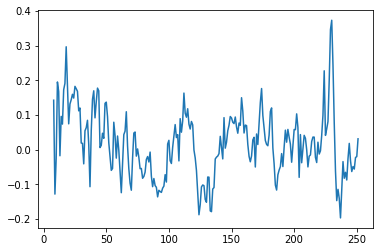

In [52]:
TLS_anoms_calendar = find_global_average_TLS(TLS_anoms_maps)
plt.plot(np.reshape(TLS_anoms_calendar, (21*12)))

np.save('ROTLSmonthly_mean_anomalies_2001_2022', TLS_anoms_calendar)